In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/STAT 4830 Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import torch

# Extract the Tar file
tar_file_path = project_path + '/spotify_skip_prediction_mini.tar'
destination_directory = 'extracted_files'
os.makedirs(destination_directory, exist_ok=True)
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=destination_directory)
print(f"Contents extracted to {destination_directory}")

/tmp/ipython-input-1802411051.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=destination_directory)


Contents extracted to extracted_files


In [ ]:
# Load Session Logs
log_mini_csv_path = os.path.join(destination_directory, 'data', 'training_set', 'log_mini.csv')
df_log_mini = pd.read_csv(log_mini_csv_path)
df_log_mini.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [ ]:
# Load Track Features
tf_mini_csv_path = os.path.join(destination_directory, 'data', 'track_features', 'tf_mini.csv')
df_tf_mini = pd.read_csv(tf_mini_csv_path)
df_tf_mini.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [ ]:
# Inspect Target Variable Distributions
df_merged = pd.merge(df_log_mini, df_tf_mini, left_on='track_id_clean', right_on='track_id')
skip_columns = ['skip_1', 'skip_2', 'skip_3', 'not_skipped']

for col in skip_columns:
    print(f"Value counts for {col}:")
    print(df_merged[col].value_counts())
    print("\n")

Value counts for skip_1:
skip_1
False    97118
True     70762
Name: count, dtype: int64


Value counts for skip_2:
skip_2
True     86824
False    81056
Name: count, dtype: int64


Value counts for skip_3:
skip_3
True     108850
False     59030
Name: count, dtype: int64


Value counts for not_skipped:
not_skipped
False    111996
True      55884
Name: count, dtype: int64




In [ ]:
print(df_merged.columns)

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector

## Merge Datasets



In [ ]:
# Merge session logs with track features
print(f"Shape of merged dataframe: {df_merged.shape}")
df_merged.head()

Shape of merged dataframe: (167880, 51)


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,4,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,4,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


### 1. Session & Interaction Logs (Raw)
These features describe the user's specific session and how they interacted with the app.

| Feature Name | Description |
| :--- | :--- |
| **`session_id`** | Unique identifier for the session that this row is a part of. |
| **`session_position`** | Numeric {1-20} indicating the position of the row within the session. |
| **`session_length`** | Numeric {10-20} indicating the total number of rows (tracks) in the session. |
| **`track_id_clean`** | Unique identifier for the track played, linked with `track_id`. |
| **`skip_1`** | Boolean indicating if the track was only played very briefly. |
| **`skip_2`** | Boolean indicating if the track was only played briefly. *(Recommended Target Variable)* |
| **`skip_3`** | Boolean indicating if most of the track was played. |
| **`not_skipped`** | Boolean indicating that the track was played in its entirety. |
| **`context_switch`** | Boolean indicating if the user changed context (e.g., switched playlists) between the previous row and the current row. |
| **`no_pause_before_play`** | Boolean indicating if there was no pause between playback of the previous track and this track. |
| **`short_pause_before_play`** | Boolean indicating if there was a short pause between playback of the previous track and this track. |
| **`long_pause_before_play`** | Boolean indicating if there was a long pause between playback of the previous track and this track. |
| **`hist_user_behavior_n_seekfwd`** | Number of times the user did a seek forward within the track. |
| **`hist_user_behavior_n_seekback`** | Number of times the user did a seek back within the track. |
| **`hist_user_behavior_is_shuffle`** | Boolean indicating if the user encountered this track while shuffle mode was activated. |
| **`hour_of_day`** | Numeric {0-23} indicating the hour of the day. |
| **`date`** | The date the session occurred (e.g., 2018-09-18). |
| **`premium`** | Boolean indicating if the user was on a premium tier or not. |
| **`context_type`** | The type of context the playback occurred within (e.g., editorial playlist). |
| **`hist_user_behavior_reason_start`** | The user action which led to the current track being played (e.g., fwdbtn). |

### 2. Track Metadata & Audio Features (Raw)
These features describe the core acoustic and metadata properties of the specific track.

| Feature Name | Description |
| :--- | :--- |
| **`track_id`** | Unique identifier for the track played, linked with `track_id_clean`. |
| **`duration`** | Length of track in seconds. |
| **`release_year`** | Estimate of the year the track was released. |
| **`us_popularity_estimate`** | Estimate of the US popularity percentile of the track as of October 12, 2018. |
| **`acousticness`, `beat_strength`, `bounciness`, `danceability`, `dyn_range_mean`, `energy`, `flatness`, `instrumentalness`, `key`, `liveness`, `loudness`, `mechanism`, `mode`, `organism`, `speechiness`, `tempo`, `time_signature`, `valence`** | Spotify continuous audio features detailing the acoustic properties of the track. |
| **`acoustic_vector_0` to `acoustic_vector_7`** | Latent, continuous 8-dimensional embedding vectors representing the deep acoustic profile of the track. |

### 3. Temporal & Global Context (Engineered)
Custom features representing the broader timing and progression of the listening session.

| Feature Name | Description |
| :--- | :--- |
| **`session_progress`** | Float [0.0 - 1.0] representing how far along the user is in the current session (`session_position` / `session_length`). |
| **`day_of_week`** | Integer representing the day of the week the session occurred (extracted from `date`). |
| **`is_weekend`** | Boolean (1/0) indicating if the session occurred on a Saturday or Sunday. |
| **`time_of_day_bucket`** | Categorical integer grouping the `hour_of_day` into broadly defined phases: Night (0), Morning (1), Afternoon (2), and Evening (3). |

### 4. Immediate Transitions / Deltas (Engineered)
Custom features capturing the "shift" or change between the *previous* track and the *current* track.

| Feature Name | Description |
| :--- | :--- |
| **`prev_reason_end`** | The user action that caused the *previous* track to end (e.g., trackdone, fwdbtn). Shifted to prevent data leakage. |
| **`delta_energy`, `delta_tempo`, `delta_valence`, `delta_loudness`, `delta_duration`, `delta_mechanism`, `delta_organism`** | The absolute numeric difference between the current track's audio feature and the previous track's audio feature. Measures how jarring the transition is. |
| **`delta_us_popularity_estimate`** | Absolute difference in popularity percentile between the current and previous track. |
| **`delta_release_year`** | Absolute difference in release year between the current and previous track. |
| **`same_key`** | Boolean (1/0) indicating if the current track and the previous track are in the exact same musical key. |
| **`same_mode`** | Boolean (1/0) indicating if the current track and previous track share the same mode (major or minor). |
| **`delta_acoustic_vector_sim`** | The Cosine Similarity [-1.0 to 1.0] between the 8-dimensional acoustic vectors of the current track and the previous track. Measures overall sonic similarity. |

### 5. Session History / The "Build-up" (Engineered)
Custom features tracking the user's cumulative behavior and the playlist's "vibe" leading up to the current track.

| Feature Name | Description |
| :--- | :--- |
| **`cum_seeks`** | The cumulative sum of all forward and backward seeks the user has made in the current session *prior* to this track. |
| **`cum_pauses`** | The cumulative sum of all short and long pauses the user has made in the current session *prior* to this track. |
| **`cum_skips`** | The total number of tracks skipped (`skip_2`) in the current session *prior* to this track. |
| **`skip_rate_so_far`** | Float [0.0 - 1.0] representing the percentage of all previous tracks in the current session that were skipped. |
| **`avg_energy_so_far`** | The expanding rolling average of the `energy` feature for all tracks played in the session *prior* to the current one. Represents the "baseline energy". |
| **`dev_energy_from_baseline`** | The difference between the current track's `energy` and the `avg_energy_so_far`. Indicates if the current song is an energy outlier. |
| **`avg_tempo_so_far`** | The expanding rolling average of the `tempo` feature for all tracks played in the session *prior* to the current one. Represents the "baseline speed". |
| **`dev_tempo_from_baseline`** | The difference between the current track's `tempo` and the `avg_tempo_so_far`. Indicates if the current song is a tempo outlier. |

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt

def engineer_spotify_features_master(df):
    # 1. Sort to prevent look-ahead leakage
    df = df.sort_values(by=['session_id', 'session_position']).copy()

    # --- 2. THE TARGET VARIABLE (y) ---
    # 1 if skipped (not_skipped is False), 0 if not skipped (not_skipped is True)
    df['y_target'] = (~df['not_skipped'].astype(bool)).astype(int)

    # --- 3. NUMERIC ENCODING FOR CATEGORICALS ---
    # Premium: True -> 1, False -> 0
    if 'premium' in df.columns:
        df['premium'] = df['premium'].astype(int)

    # Shuffle: True -> 1, False -> 0
    if 'hist_user_behavior_is_shuffle' in df.columns:
        df['hist_user_behavior_is_shuffle'] = df['hist_user_behavior_is_shuffle'].astype(int)

    # Mode: major -> 1, minor -> 0
    if df['mode'].dtype == 'object':
        df['mode'] = df['mode'].map({'major': 1, 'minor': 0}).fillna(0)

    # Key: Strings to 0-11
    if df['key'].dtype == 'object':
        key_map = {k: i for i, k in enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])}
        df['key'] = df['key'].map(key_map).fillna(0)

    # Label Encoding for multi-category strings
    categorical_cols = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category').cat.codes

    # --- 4. TEMPORAL & CONTEXT ---
    df['session_progress'] = df['session_position'] / df['session_length']
    df['date_dt'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date_dt'].dt.dayofweek.astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    bins = [-1, 6, 12, 17, 21, 24]
    labels = [0, 1, 2, 3, 0]
    df['time_of_day_bucket'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels, ordered=False).astype(int)

    # --- 5. TRACK SHIFTS (For Deltas) ---
    features_to_shift = [
        'energy', 'tempo', 'valence', 'loudness', 'duration',
        'mechanism', 'organism', 'us_popularity_estimate',
        'release_year', 'key', 'mode'
    ]
    for feat in features_to_shift:
        df[f'prev_{feat}'] = df.groupby('session_id')[feat].shift(1)

    # --- 6. TRANSITIONS (Deltas) ---
    continuous_deltas = ['energy', 'tempo', 'valence', 'loudness', 'duration',
                         'mechanism', 'organism', 'us_popularity_estimate', 'release_year']
    for feat in continuous_deltas:
        df[f'delta_{feat}'] = abs(df[feat].astype(float) - df[f'prev_{feat}'].astype(float))

    df['same_key'] = (df['key'] == df['prev_key']).astype(int)
    df['same_mode'] = (df['mode'] == df['prev_mode']).astype(int)

    # Acoustic Vector Similarity
    vec_cols = [f'acoustic_vector_{i}' for i in range(8)]
    for c in vec_cols:
        df[f'prev_{c}'] = df.groupby('session_id')[c].shift(1)

    dot_product = (df[vec_cols].values * df[[f'prev_{c}' for c in vec_cols]].values).sum(axis=1)
    norm_curr = np.linalg.norm(df[vec_cols].values, axis=1)
    norm_prev = np.linalg.norm(df[[f'prev_{c}' for c in vec_cols]].values, axis=1)
    df['delta_acoustic_vector_sim'] = np.nan_to_num(dot_product / (norm_curr * norm_prev), nan=0.0)

    # --- 7. SESSION HISTORY (Cumulative Skips) ---
    df['previous_tracks'] = df['session_position'] - 1
    # Use the target we just created for history to avoid leakage
    df['past_skip'] = df.groupby('session_id')['y_target'].shift(1).fillna(0)
    df['cum_skips'] = df.groupby('session_id')['past_skip'].cumsum()
    df['skip_rate_so_far'] = np.where(df['previous_tracks'] > 0, df['cum_skips'] / df['previous_tracks'], 0)

    df['past_seek'] = df.groupby('session_id')['hist_user_behavior_n_seekfwd'].shift(1).fillna(0) + \
                      df.groupby('session_id')['hist_user_behavior_n_seekback'].shift(1).fillna(0)
    df['cum_seeks'] = df.groupby('session_id')['past_seek'].cumsum()

    df['past_pause'] = df.groupby('session_id')['short_pause_before_play'].shift(1).astype(float).fillna(0) + \
                       df.groupby('session_id')['long_pause_before_play'].shift(1).astype(float).fillna(0)
    df['cum_pauses'] = df.groupby('session_id')['past_pause'].cumsum()

    # Baseline Deviations
    for feat in ['energy', 'tempo']:
        past_feat = df.groupby('session_id')[feat].shift(1).fillna(0)
        cum_sum = past_feat.groupby(df['session_id']).cumsum()
        df[f'avg_{feat}_so_far'] = np.where(df['previous_tracks'] > 0, cum_sum / df['previous_tracks'], df[feat])
        df[f'dev_{feat}_from_baseline'] = df[feat] - df[f'avg_{feat}_so_far']

    return df

In [ ]:
# ---------------------------------------------------------
# EXECUTION & UNSCALED SPLIT (DATAFRAMES ONLY)
# ---------------------------------------------------------

# 1. Run Engineering Master
# Using your df_merged as the input source
df_final = engineer_spotify_features_master(df_merged)

# 2. Master Feature List (Raw + Context + Deltas + History)
feature_names_list = [
    # Metadata & User Context
    'premium', 'hist_user_behavior_is_shuffle', 'hour_of_day',
    'context_switch', 'no_pause_before_play', 'time_signature',

    # Categorical Context (We will encode these in the next step)
    'context_type', 'hist_user_behavior_reason_start',

    # Raw Track Audio Features
    'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
    'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
    'energy', 'flatness', 'instrumentalness', 'key', 'liveness',
    'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
    'tempo', 'valence',

    # Raw Acoustic Vectors (0-7)
    'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
    'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
    'acoustic_vector_6', 'acoustic_vector_7',

    # Engineered Context & Time
    'session_progress', 'day_of_week', 'is_weekend', 'time_of_day_bucket',

    # Engineered Deltas (Transitions)
    'delta_energy', 'delta_tempo', 'delta_valence', 'delta_loudness',
    'delta_duration', 'delta_mechanism', 'delta_organism',
    'delta_us_popularity_estimate', 'delta_release_year',
    'same_key', 'same_mode', 'delta_acoustic_vector_sim',

    # Engineered Session History
    'cum_skips', 'skip_rate_so_far', 'cum_seeks', 'cum_pauses',
    'dev_energy_from_baseline', 'dev_tempo_from_baseline',
]

df_clean = df_final.dropna(subset=['delta_energy']).copy()

# Initialize GroupShuffleSplit to keep sessions intact within splits
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

# Generate indices based on session_id to prevent data leakage
train_idx, test_idx = next(gss.split(df_clean, groups=df_clean['session_id']))

# 4. Extract Training and Testing DataFrames
X_train_df = df_clean.iloc[train_idx][feature_names_list]
X_test_df  = df_clean.iloc[test_idx][feature_names_list]

# Extract target DataFrames (y=1 if skip, y=0 if full play)
y_train_df = df_clean.iloc[train_idx][['y_target']]
y_test_df  = df_clean.iloc[test_idx][['y_target']]

# 5. Verify the Split
print(f"--- Split Summary ---")
print(f"Total Clean Rows:  {len(df_clean)}")
print(f"Train Sessions:    {df_clean.iloc[train_idx]['session_id'].nunique()}")
print(f"Test Sessions:     {df_clean.iloc[test_idx]['session_id'].nunique()}")
print(f"X_train Shape:     {X_train_df.shape}")
print(f"X_test Shape:      {X_test_df.shape}")
print(f"Skip Rate (Train): {y_train_df['y_target'].mean():.2%}")

--- Split Summary ---
Total Clean Rows:  157880
Train Sessions:    8000
Test Sessions:     2000
X_train Shape:     (126268, 58)
X_test Shape:      (31612, 58)
Skip Rate (Train): 66.49%


In [ ]:
X_train_df.dtypes

,0
premium,int64
hist_user_behavior_is_shuffle,int64
hour_of_day,int64
context_switch,int64
no_pause_before_play,int64
time_signature,int64
context_type,int8
hist_user_behavior_reason_start,int8
duration,float64
release_year,int64


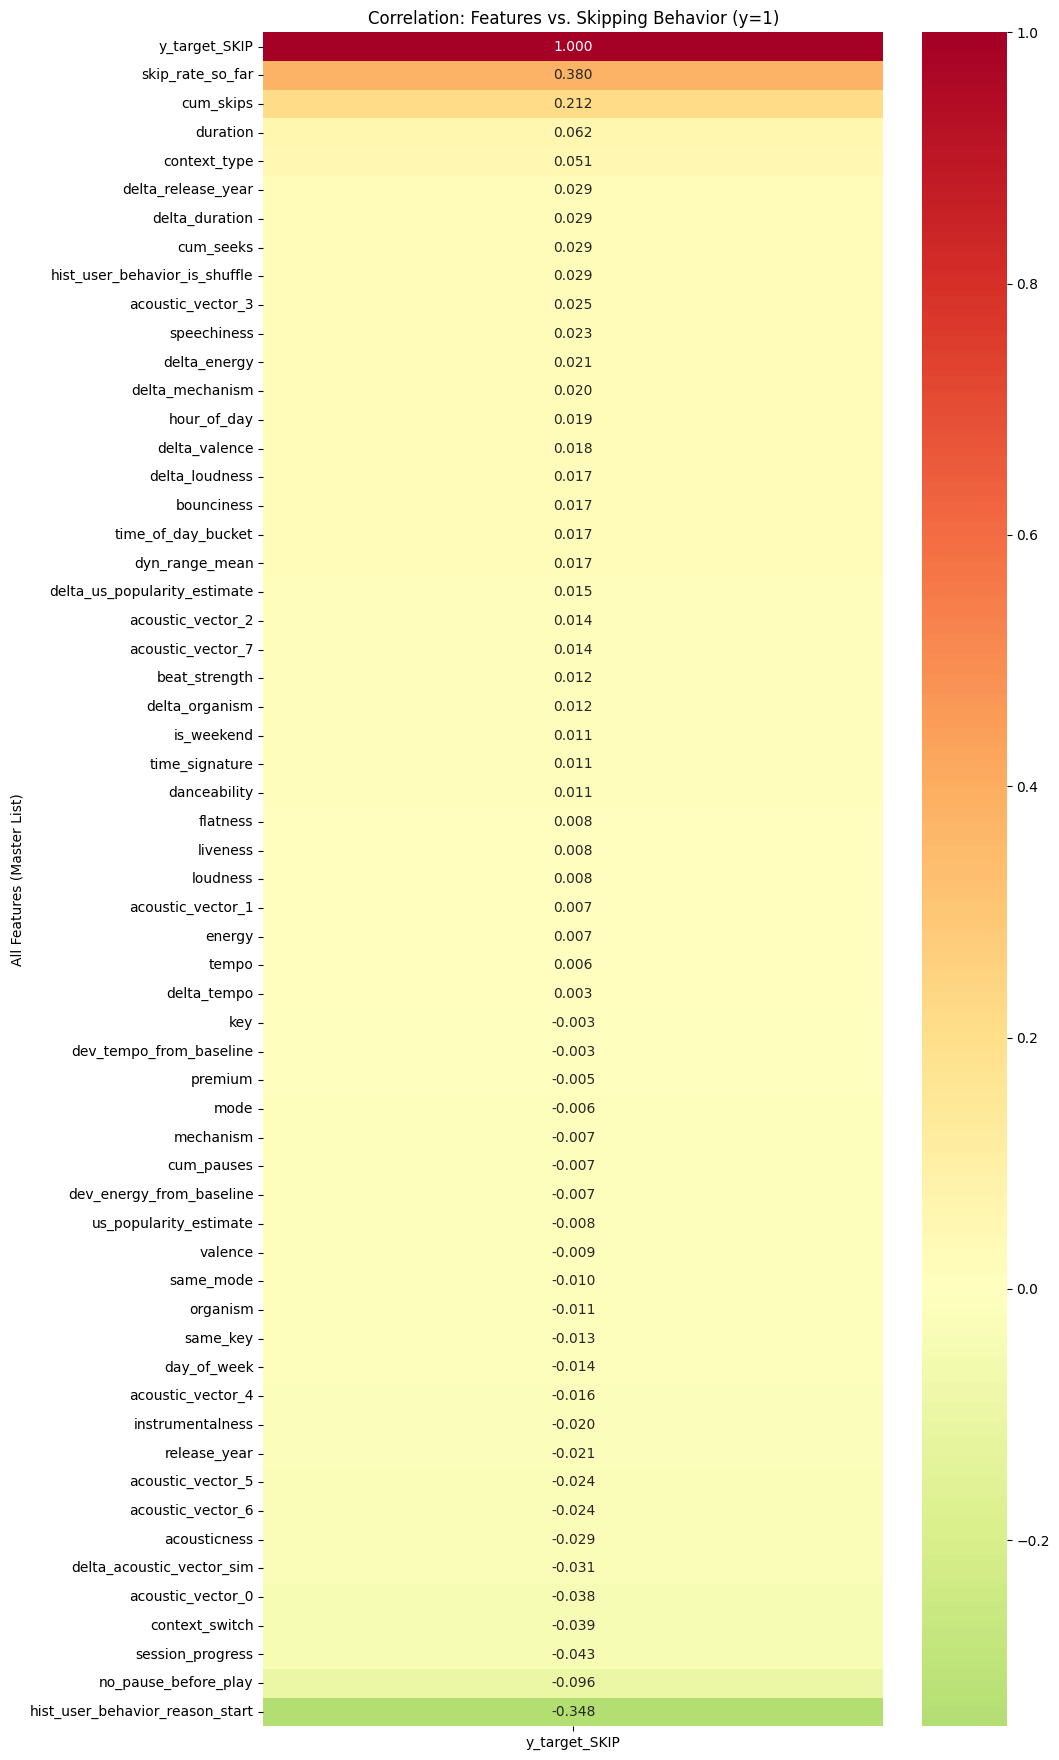

Top 5 Skip Drivers (Highest Positive Correlation):
                    y_target_SKIP
skip_rate_so_far         0.380081
cum_skips                0.212274
duration                 0.062272
context_type             0.051460
delta_release_year       0.029023

Top 5 Retention Drivers (Highest Negative Correlation):
                                 y_target_SKIP
acoustic_vector_0                    -0.037950
context_switch                       -0.039083
session_progress                     -0.042535
no_pause_before_play                 -0.095633
hist_user_behavior_reason_start      -0.348091


In [ ]:
# ---------------------------------------------------------
# CORRELATION ANALYSIS: THE "LITERAL EVERYTHING" LIST
# ---------------------------------------------------------

# 1. Combine X and y for the training set to calculate correlations
# We use .copy() to avoid SettingWithCopy warnings
corr_df = X_train_df.copy()
corr_df['y_target_SKIP'] = y_train_df['y_target'].values

# 2. Calculate the Correlation Matrix
# We force everything to float to ensure numeric stability during calculation
full_corr_matrix = corr_df.astype(float).corr()

# 3. Isolate the correlation with our Skip Target
# We sort descending so the strongest skip predictors are at the top
target_corr_ranked = full_corr_matrix[['y_target_SKIP']].sort_values(by='y_target_SKIP', ascending=False)

# 4. Plotting the Ranked Heatmap
plt.figure(figsize=(10, 22))

# Using 'RdYlGn_r' (Red-Yellow-Green Reversed)
# Positive correlation (Skip) = Red
# Negative correlation (Listen) = Green
sns.heatmap(target_corr_ranked,
            annot=True,
            cmap='RdYlGn_r',
            fmt=".3f",
            center=0)

plt.title("Correlation: Features vs. Skipping Behavior (y=1)")
plt.ylabel("All Features (Master List)")
plt.show()

# 5. (Optional) Print the Top 5 Skip Drivers and Top 5 Retention Drivers
print("Top 5 Skip Drivers (Highest Positive Correlation):")
print(target_corr_ranked.head(6)[1:]) # Exclude the target itself
print("\nTop 5 Retention Drivers (Highest Negative Correlation):")
print(target_corr_ranked.tail(5))

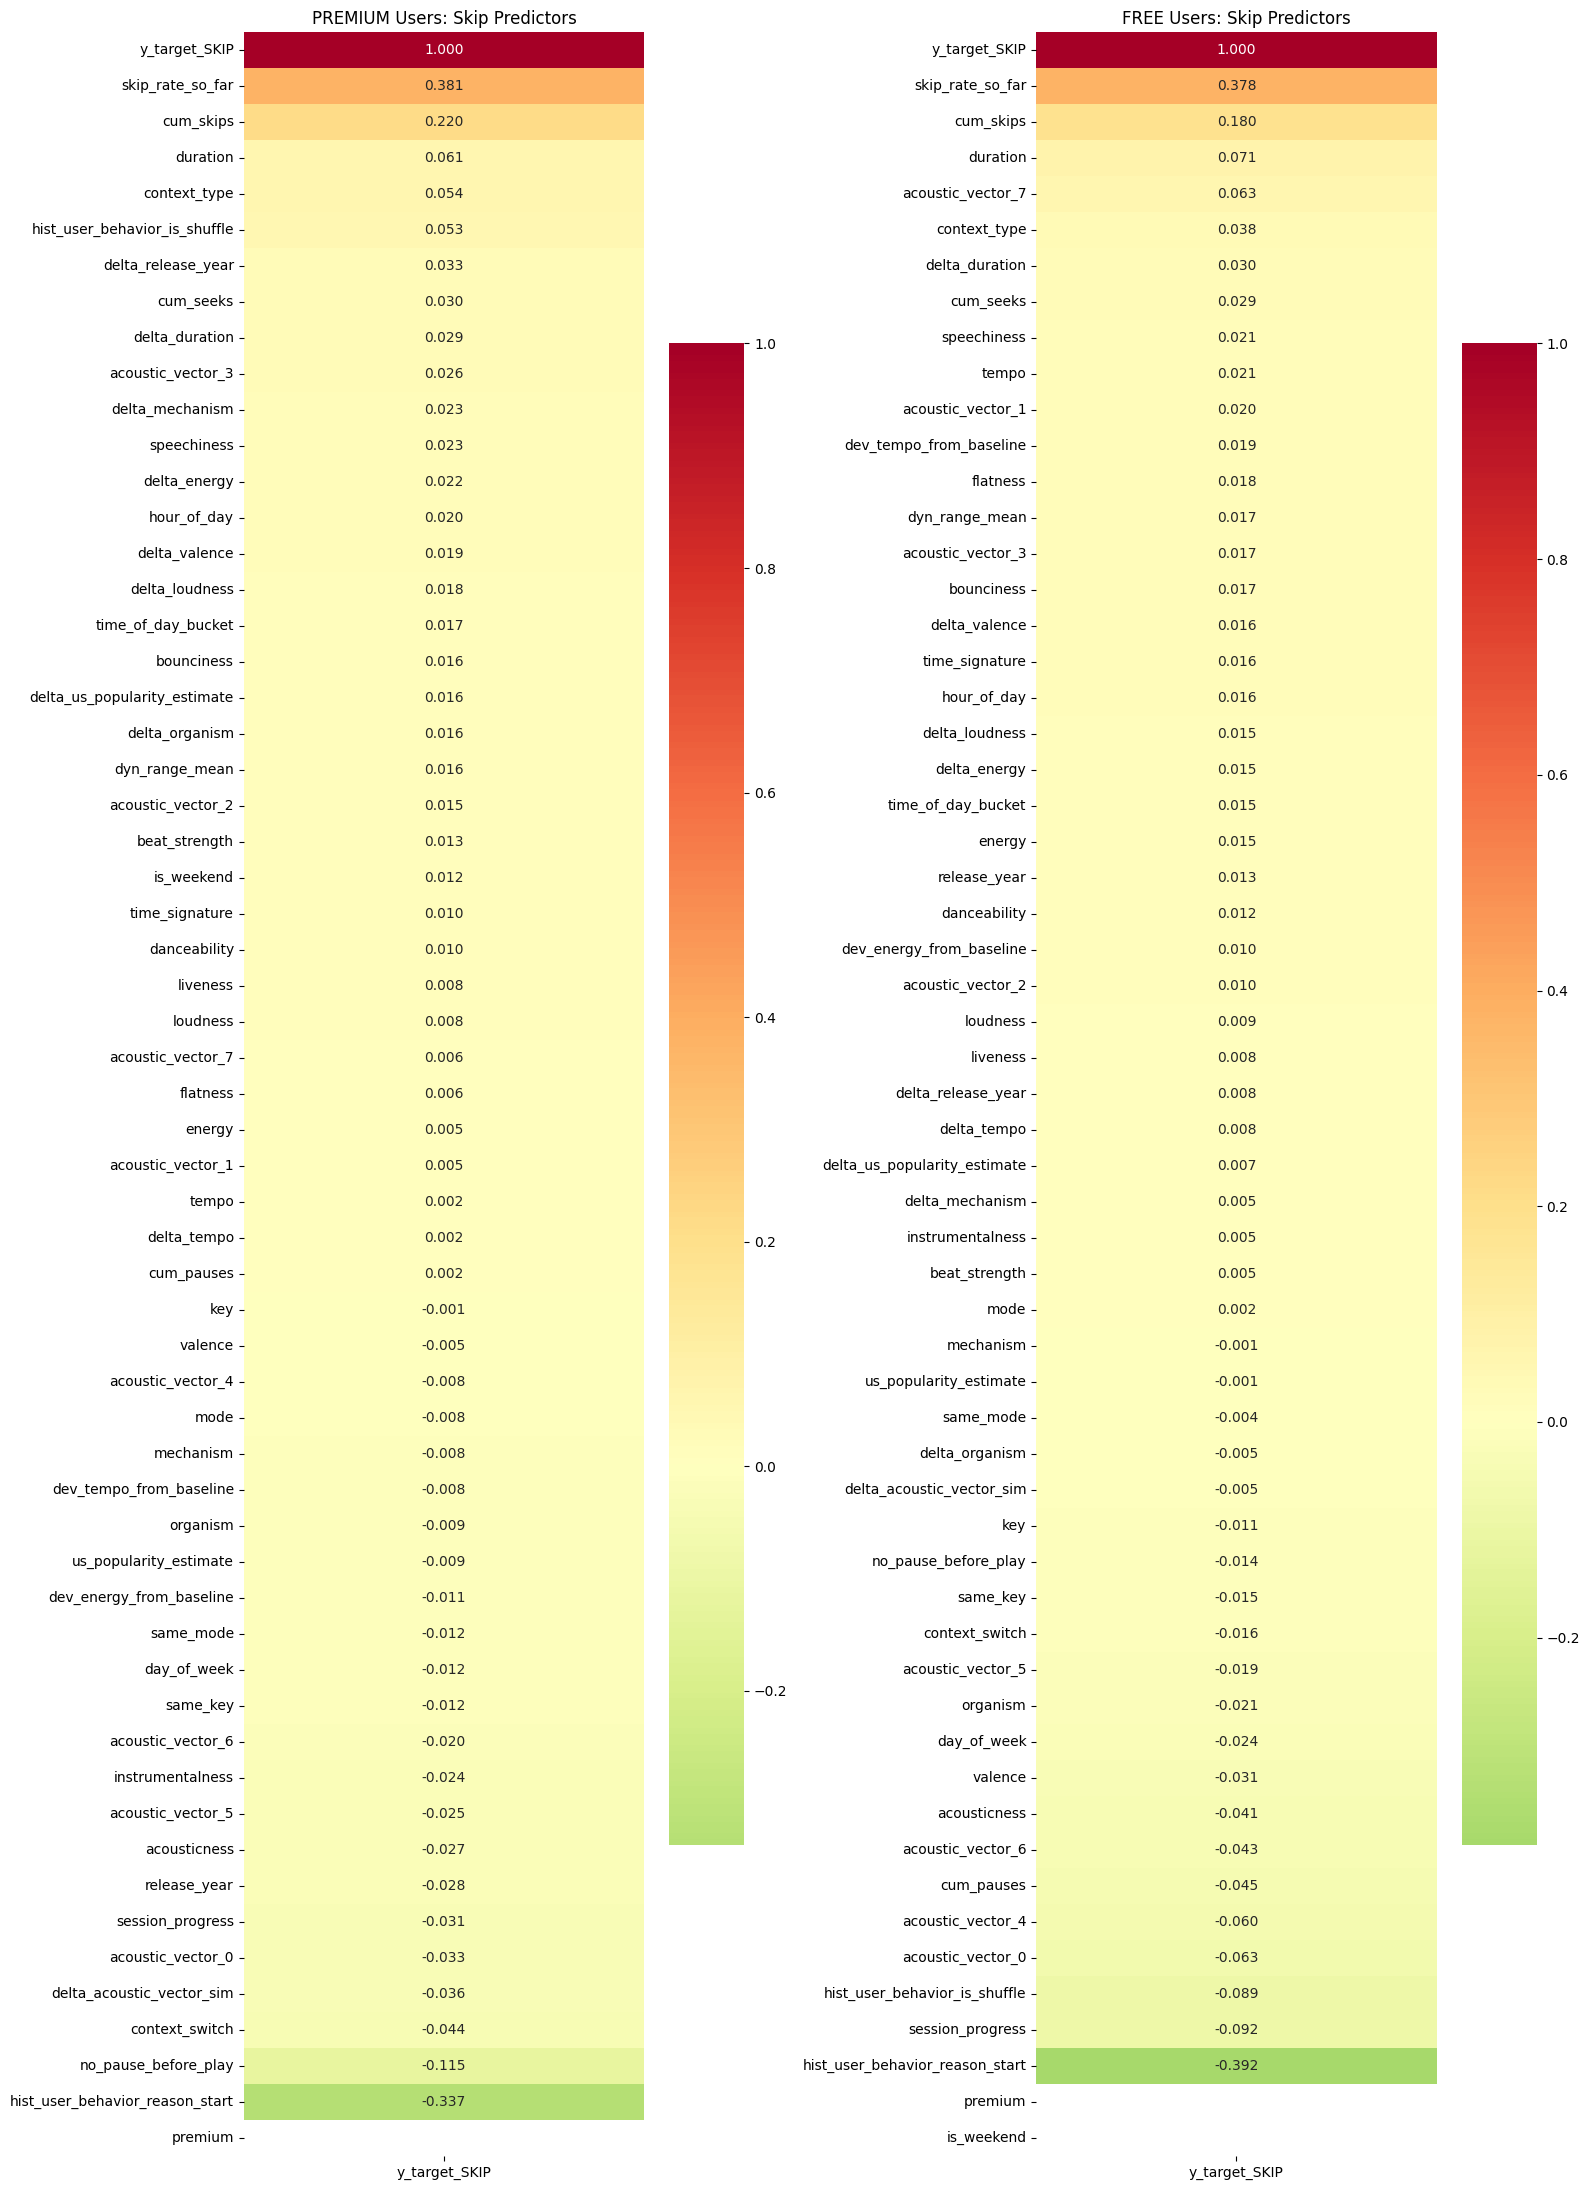

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-attach the target and premium status for filtering
analysis_df = X_train_df.copy()
analysis_df['y_target_SKIP'] = y_train_df['y_target'].values

# 2. Separate the DataFrames
premium_df = analysis_df[analysis_df['premium'] == 1]
free_df = analysis_df[analysis_df['premium'] == 0]

# 3. Calculate Correlations for both
corr_premium = premium_df.astype(float).corr()[['y_target_SKIP']].sort_values(by='y_target_SKIP', ascending=False)
corr_free = free_df.astype(float).corr()[['y_target_SKIP']].sort_values(by='y_target_SKIP', ascending=False)

# 4. Plot Side-by-Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 22))

# Premium Plot
sns.heatmap(corr_premium, annot=True, cmap='RdYlGn_r', fmt=".3f", center=0, ax=ax1)
ax1.set_title("PREMIUM Users: Skip Predictors")

# Free Plot
sns.heatmap(corr_free, annot=True, cmap='RdYlGn_r', fmt=".3f", center=0, ax=ax2)
ax2.set_title("FREE Users: Skip Predictors")

plt.tight_layout()
plt.show()

In [ ]:
def baseline_score(X_df, df_reference, features=None):
    """
    X_df: The feature DataFrame (X_train_df or X_test_df)
    df_reference: The original cleaned DataFrame containing 'session_id'
                  at the same indices as X_df.
    features: (Optional) List of feature names to use. If None, uses all columns.
    """
    # Filter features if a list is provided
    if features is not None:
        X_used = X_df[features]
    else:
        X_used = X_df

    # 1. We must shift WITHIN each session
    # We use df_reference to align the session_id with the rows in X_df
    # Note: We rely on X_used having the same index as X_df/df_reference
    prev_features_df = X_used.groupby(df_reference.loc[X_used.index, 'session_id']).shift(1).fillna(0)

    current_features = X_used.values
    prev_features = prev_features_df.values

    # 2. Calculate the Dot Product (a_i^T * b_j)
    # This now only multiplies songs within the same session.
    # Song 1 of any session will have a dot product of 0 (no previous song).
    dot_products = np.sum(current_features * prev_features, axis=1)

    return dot_products


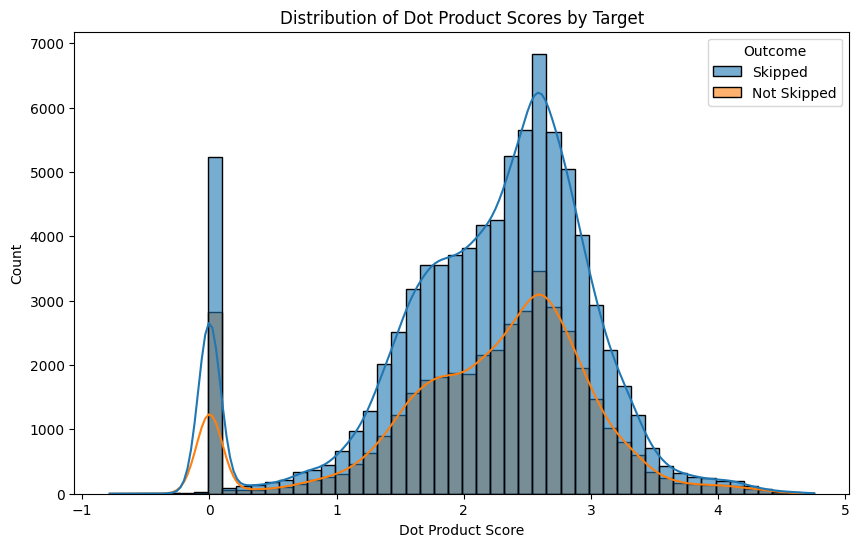

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'Dot Product': train_dot_products,
    'Outcome': y_train_df['y_target'].map({1: 'Skipped', 0: 'Not Skipped'})
})

plt.figure(figsize=(10, 6))
# element="step" makes the overlapping distributions easier to see
sns.histplot(data=plot_df, x='Dot Product', hue='Outcome', kde=True, bins=50, alpha=0.6)
plt.title("Distribution of Dot Product Scores by Target")
plt.xlabel("Dot Product Score")
plt.ylabel("Count")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# --- Step 1: Prepare the Session-Aware 'Previous' Data ---
def prepare_bilinear_data(X_df, df_ref, feature_list):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df[feature_list])
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_list, index=X_df.index)

    # Within-session shift
    X_prev_scaled_df = X_scaled_df.groupby(df_ref.loc[X_df.index, 'session_id']).shift(1).fillna(0)

    curr_ts = torch.tensor(X_scaled_df.values, dtype=torch.float32)
    prev_ts = torch.tensor(X_prev_scaled_df.values, dtype=torch.float32)

    return curr_ts, prev_ts, scaler

# --- Step 2: Define the Professor's Bilinear Model ---
class BilinearTransitionModel(nn.Module):
    def __init__(self, input_dim):
        super(BilinearTransitionModel, self).__init__()
        # Xavier initialization helps with full-batch convergence
        self.W = nn.Parameter(torch.Tensor(input_dim, 1))
        nn.init.xavier_uniform_(self.W)

        self.bias = nn.Parameter(torch.zeros(1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, a_i, b_j):
        interaction = a_i * b_j
        logits = torch.mm(interaction, self.W) + self.bias
        return self.sigmoid(logits)

# --- Step 3: Optimization Loop (Full Batch Style) ---
features_to_test = X_train_df.columns.tolist()

# Prepare Tensors
curr_train, prev_train, _ = prepare_bilinear_data(X_train_df, df_clean, features_to_test)
y_train = torch.tensor(y_train_df.values, dtype=torch.float32)

# Initialize Model
model = BilinearTransitionModel(len(features_to_test))

# In Full Batch, we can afford a slightly higher learning rate (0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#Add more importance on getting 0 (no skip) correct than 1.
pos_weight = torch.tensor([0.8])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# Train to minimize Log-Loss
for epoch in range(1000): # Increased epochs because updates are less frequent
    model.train()
    optimizer.zero_grad()

    # Passing the ENTIRE dataset at once
    preds = model(curr_train, prev_train)
    loss = criterion(preds, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Full-Batch Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.5f}")

# --- Step 4: Extract Optimized W ---
optimized_weights = model.W.detach().numpy().flatten()
W_df = pd.DataFrame({'Feature': features_to_test, 'Optimized_Weight': optimized_weights})
print("\n--- Optimized Weights (W) ---")
print(W_df.sort_values(by='Optimized_Weight', ascending=False))

Epoch 0 | Full-Batch Loss: 0.5892 | LR: 0.00100
Epoch 10 | Full-Batch Loss: 0.5883 | LR: 0.00100
Epoch 20 | Full-Batch Loss: 0.5874 | LR: 0.00100
Epoch 30 | Full-Batch Loss: 0.5865 | LR: 0.00100
Epoch 40 | Full-Batch Loss: 0.5856 | LR: 0.00100
Epoch 50 | Full-Batch Loss: 0.5847 | LR: 0.00100
Epoch 60 | Full-Batch Loss: 0.5838 | LR: 0.00100
Epoch 70 | Full-Batch Loss: 0.5829 | LR: 0.00100
Epoch 80 | Full-Batch Loss: 0.5820 | LR: 0.00100
Epoch 90 | Full-Batch Loss: 0.5812 | LR: 0.00100
Epoch 100 | Full-Batch Loss: 0.5803 | LR: 0.00100
Epoch 110 | Full-Batch Loss: 0.5795 | LR: 0.00100
Epoch 120 | Full-Batch Loss: 0.5787 | LR: 0.00100
Epoch 130 | Full-Batch Loss: 0.5780 | LR: 0.00100
Epoch 140 | Full-Batch Loss: 0.5774 | LR: 0.00100
Epoch 150 | Full-Batch Loss: 0.5767 | LR: 0.00100
Epoch 160 | Full-Batch Loss: 0.5760 | LR: 0.00100
Epoch 170 | Full-Batch Loss: 0.5754 | LR: 0.00100
Epoch 180 | Full-Batch Loss: 0.5748 | LR: 0.00100
Epoch 190 | Full-Batch Loss: 0.5742 | LR: 0.00100
Epoch 200 |


--- Model Evaluation ---
Accuracy: 0.6236
AUC-ROC:  0.6336


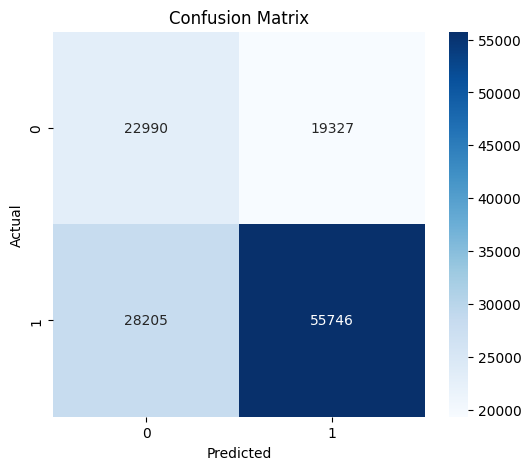

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

def evaluate_model(model, curr_ts, prev_ts, y_ts):
    model.eval()
    with torch.no_grad():
        # Get probability predictions
        probs = model(curr_ts, prev_ts).numpy().flatten()
        # Convert probabilities to binary (0 or 1) using 0.5 threshold
        preds = (probs > 0.5).astype(int)
        actuals = y_ts.numpy().flatten()

        auc = roc_auc_score(actuals, probs)
        acc = accuracy_score(actuals, preds)

        print(f"\n--- Model Evaluation ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"AUC-ROC:  {auc:.4f}")

        # Plotting the Confusion Matrix
        cm = confusion_matrix(actuals, preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

# Run on Training Data (for now)
evaluate_model(model, curr_train, prev_train, y_train)

In [ ]:
# Calculate value counts for the test set target variable
skip_counts = y_test_df['y_target'].value_counts()
print("Test Set Skip Counts:")
print(skip_counts)

# Optional: Print as percentage
print("\nTest Set Skip Percentages:")
print(y_test_df['y_target'].value_counts(normalize=True))

Test Set Skip Counts:
y_target
1    21467
0    10145
Name: count, dtype: int64

Test Set Skip Percentages:
y_target
1    0.679078
0    0.320922
Name: proportion, dtype: float64


In [ ]:
# 1. Define the core audio features we want to use for the Bilinear vectors
core_features = [
    'duration', 'us_popularity_estimate', 'acousticness', 'beat_strength',
    'bounciness', 'danceability', 'dyn_range_mean', 'energy', 'flatness',
    'instrumentalness', 'liveness', 'loudness', 'mechanism', 'organism',
    'speechiness', 'tempo', 'valence'
] + [f'acoustic_vector_{i}' for i in range(8)]

# 2. Sort to guarantee chronological order
df = df.sort_values(by=['session_id', 'session_position']).copy()

# 3. Create the previous song features (a_i)
for feat in core_features:
    df[f'prev_{feat}'] = df.groupby('session_id')[feat].shift(1)

# 4. Drop the first track of every session (since it has no previous track to transition from)
df_clean = df.dropna(subset=[f'prev_{core_features[0]}']).copy()

# 5. Map the target to +1 (Skip) and -1 (No Skip) for the margin loss
df_clean['y_margin'] = np.where(df_clean['skip_2'] == 1, 1.0, -1.0)

# 6. Extract our arrays
X_a_raw = df_clean[[f'prev_{f}' for f in core_features]].values # Previous song
X_b_raw = df_clean[core_features].values                        # Current song
y_raw = df_clean['y_margin'].values                             # Target
session_groups = df_clean['session_id'].values                  # For splitting

# 7. Session-Aware Train/Test Split (80% Train, 20% Test)
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, test_idx = next(gss.split(X_a_raw, y_raw, groups=session_groups))

X_a_train, X_a_test = X_a_raw[train_idx], X_a_raw[test_idx]
X_b_train, X_b_test = X_b_raw[train_idx], X_b_raw[test_idx]
y_train, y_test = y_raw[train_idx], y_raw[test_idx]

# 8. Scale the features (Fit ONLY on train data to prevent data leakage)
# We scale both A and B using the same scaler because they belong to the same feature space!
scaler = StandardScaler()
scaler.fit(np.vstack((X_a_train, X_b_train))) # Fit on all songs in training

X_a_train_scaled = scaler.transform(X_a_train)
X_b_train_scaled = scaler.transform(X_b_train)
X_a_test_scaled = scaler.transform(X_a_test)
X_b_test_scaled = scaler.transform(X_b_test)

# Convert arrays to PyTorch Tensors
X_a_train_t = torch.FloatTensor(X_a_train_scaled)
X_b_train_t = torch.FloatTensor(X_b_train_scaled)
y_train_t = torch.FloatTensor(y_train)

X_a_test_t = torch.FloatTensor(X_a_test_scaled)
X_b_test_t = torch.FloatTensor(X_b_test_scaled)
y_test_t = torch.FloatTensor(y_test)

print(f"Training transitions: {len(y_train_t)}")
print(f"Testing transitions: {len(y_test_t)}")

Training transitions: 126268
Testing transitions: 31612


In [ ]:
import torch.nn as nn

class BilinearSkipModel(nn.Module):
    def __init__(self, num_features):
        super(BilinearSkipModel, self).__init__()
        # W is the weight vector (initialized to all ones)
        self.W = nn.Parameter(torch.ones(num_features))
        # Optional bias term
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, a, b):
        # Element-wise multiplication: a_i * W * b_j
        # Then we sum across the features (dim=1) to get the final score
        score = torch.sum(a * self.W * b, dim=1) + self.bias
        return score

In [ ]:
import torch.optim as optim

def train_bilinear_model(X_a, X_b, y, num_epochs=500, learning_rate=0.01, use_ridge=False, ridge_lambda=0.01):
    num_features = X_a.shape[1]
    model = BilinearSkipModel(num_features)

    # We use Adam optimizer to update the weights in W
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1. Forward Pass (Get the a^T W b scores)
        scores = model(X_a, X_b)

        # 2. Calculate Professor's Margin Loss: log(1 + exp(-y * score))
        # Note: PyTorch's Softplus(x) is mathematically identical to log(1 + exp(x)) and is much more numerically stable!
        margin_loss = nn.functional.softplus(-y * scores).mean()

        # 3. Add Ridge Regularization (Optional)
        if use_ridge:
            l2_penalty = ridge_lambda * torch.sum(model.W ** 2)
            loss = margin_loss + l2_penalty
        else:
            loss = margin_loss

        # 4. Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")

    return model

# --- EXECUTION ---

print("--- Training WITHOUT Ridge ---")
model_no_ridge = train_bilinear_model(
    X_a_train_t, X_b_train_t, y_train_t,
    num_epochs=500,
    learning_rate=0.05,
    use_ridge=False
)

print("\n--- Training WITH Ridge (L2) ---")
model_with_ridge = train_bilinear_model(
    X_a_train_t, X_b_train_t, y_train_t,
    num_epochs=500,
    learning_rate=0.05,
    use_ridge=True,
    ridge_lambda=0.1 # You can tune this penalty
)

--- Training WITHOUT Ridge ---
Epoch 100/500 | Loss: 0.6911
Epoch 200/500 | Loss: 0.6902
Epoch 300/500 | Loss: 0.6902
Epoch 400/500 | Loss: 0.6901
Epoch 500/500 | Loss: 0.6901

--- Training WITH Ridge (L2) ---
Epoch 100/500 | Loss: 0.6910
Epoch 200/500 | Loss: 0.6905
Epoch 300/500 | Loss: 0.6905
Epoch 400/500 | Loss: 0.6905
Epoch 500/500 | Loss: 0.6905


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupShuffleSplit

# 1. Sort chronologically
df = df.sort_values(by=['session_id', 'session_position']).copy()

# 2. Get the previous track ID
df['prev_track_id_clean'] = df.groupby('session_id')['track_id_clean'].shift(1)

# 3. Drop the first track of every session
df_clean = df.dropna(subset=['prev_track_id_clean']).copy()

# 4. Map the target to +1 (Skip) and -1 (No Skip)
df_clean['y_margin'] = np.where(df_clean['skip_2'] == 1, 1.0, -1.0)

# 5. Create the "Vocabulary" of unique tracks
all_unique_tracks = pd.concat([df_clean['prev_track_id_clean'], df_clean['track_id_clean']]).unique()
num_unique_tracks = len(all_unique_tracks)
print(f"Total Unique Tracks in Dataset: {num_unique_tracks}")

# 6. Build the Dictionary (String -> Integer)
track_to_idx = {track: idx for idx, track in enumerate(all_unique_tracks)}

# 7. Apply the mapping to our dataframe
df_clean['prev_idx'] = df_clean['prev_track_id_clean'].map(track_to_idx)
df_clean['curr_idx'] = df_clean['track_id_clean'].map(track_to_idx)

# 8. Extract Arrays for Splitting
X_prev = df_clean['prev_idx'].values
X_curr = df_clean['curr_idx'].values
y_raw = df_clean['y_margin'].values
session_groups = df_clean['session_id'].values

# 9. Session-Aware Train/Test Split
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, test_idx = next(gss.split(X_prev, y_raw, groups=session_groups))

# 10. Convert directly to PyTorch LongTensors (required for Embeddings)
prev_train_t = torch.LongTensor(X_prev[train_idx])
curr_train_t = torch.LongTensor(X_curr[train_idx])
y_train_t = torch.FloatTensor(y_raw[train_idx])

prev_test_t = torch.LongTensor(X_prev[test_idx])
curr_test_t = torch.LongTensor(X_curr[test_idx])
y_test_t = torch.FloatTensor(y_raw[test_idx])

Total Unique Tracks in Dataset: 50704


In [ ]:
class LatentBilinearModel(nn.Module):
    def __init__(self, num_tracks, embed_dim=32):
        super(LatentBilinearModel, self).__init__()

        # The Lookup Tables (Embeddings)
        # We initialize them with tiny random numbers
        self.embed_A = nn.Embedding(num_embeddings=num_tracks, embedding_dim=embed_dim)
        self.embed_B = nn.Embedding(num_embeddings=num_tracks, embedding_dim=embed_dim)

        # Your brilliant idea: The trainable feature weight vector W
        self.W = nn.Parameter(torch.ones(embed_dim))

        # Bias term
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, prev_idx, curr_idx):
        # 1. Look up the 32-dimensional vectors for the given song integers
        a = self.embed_A(prev_idx)  # Shape: (batch_size, 32)
        b = self.embed_B(curr_idx)  # Shape: (batch_size, 32)

        # 2. Compute the weighted dot product: sum(a * W * b)
        score = torch.sum(a * self.W * b, dim=1) + self.bias
        return score

In [ ]:
def train_latent_model(prev_train, curr_train, y_train, num_tracks, num_epochs=100, lr=0.01, ridge_lambda=1e-4):
    # Initialize the model
    model = LatentBilinearModel(num_tracks, embed_dim=32)

    # We use SparseAdam or standard Adam. Adam is fine for this scale.
    # We add weight_decay directly in the optimizer (which is Ridge/L2 regularization!)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=ridge_lambda)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1. Forward Pass
        scores = model(prev_train, curr_train)

        # 2. Professor's Margin Loss using Softplus: log(1 + exp(-y * score))
        loss = nn.functional.softplus(-y_train * scores).mean()

        # 3. Backward Pass
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d}/{num_epochs} | Loss: {loss.item():.4f}")

    return model

# --- EXECUTION ---
print("Training Latent Bilinear Model...")
# Note: We pass in 'num_unique_tracks' so the Embedding layer knows how big the lookup table needs to be.
latent_model = train_latent_model(
    prev_train_t, curr_train_t, y_train_t,
    num_tracks=num_unique_tracks,
    num_epochs=100,
    lr=0.05,
    ridge_lambda=0 # This is the L2 penalty
)

Training Latent Bilinear Model...
Epoch 010/100 | Loss: 0.3020
Epoch 020/100 | Loss: 0.2179
Epoch 030/100 | Loss: 0.1954
Epoch 040/100 | Loss: 0.1825
Epoch 050/100 | Loss: 0.1749
Epoch 060/100 | Loss: 0.1704
Epoch 070/100 | Loss: 0.1676
Epoch 080/100 | Loss: 0.1657
Epoch 090/100 | Loss: 0.1644
Epoch 100/100 | Loss: 0.1634


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_latent_model(prev_train, curr_train, y_train, num_tracks, num_epochs=100, lr=0.01, l1_lambda=1e-4):
    # Initialize the model
    model = LatentBilinearModel(num_tracks, embed_dim=32)

    # We use standard Adam.
    # CRITICAL CHANGE: weight_decay is set to 0.0 because we are doing L1 manually!
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1. Forward Pass
        scores = model(prev_train, curr_train)

        # 2. Professor's Margin Loss using Softplus: log(1 + exp(-y * score))
        margin_loss = nn.functional.softplus(-y_train * scores).mean()

        # 3. CRITICAL CHANGE: Calculate manual L1 Penalty (sum of absolute weights)
        l1_penalty = 0.0
        for param in model.parameters():
            l1_penalty += torch.sum(torch.abs(param))

        # Add the L1 penalty to the main loss
        loss = margin_loss + l1_lambda * l1_penalty

        # 4. Backward Pass
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d}/{num_epochs} | Loss: {loss.item():.4f}")

    return model

# --- EXECUTION ---
print("Training Latent Bilinear Model with L1 Regularization...")
# Note: We pass in 'num_unique_tracks' so the Embedding layer knows how big the lookup table needs to be.
latent_model = train_latent_model(
    prev_train_t, curr_train_t, y_train_t,
    num_tracks=num_unique_tracks,
    num_epochs=100,
    lr=0.05,
    l1_lambda=1e-4 # This is now the L1 penalty
)

Training Latent Bilinear Model with L1 Regularization...
Epoch 010/100 | Loss: 144.3476
Epoch 020/100 | Loss: 71.1672
Epoch 030/100 | Loss: 34.4496
Epoch 040/100 | Loss: 17.1009
Epoch 050/100 | Loss: 8.9961
Epoch 060/100 | Loss: 5.5577
Epoch 070/100 | Loss: 3.9073
Epoch 080/100 | Loss: 3.2588
Epoch 090/100 | Loss: 2.9577
Epoch 100/100 | Loss: 2.7962


In [ ]:
# Define binary target
if 'skipped' not in df.columns:
    df['skipped'] = (df['skip_1'] | df['skip_2'] | df['skip_3']).astype(int)

# Simple bins
if 'duration_bin' not in df.columns:
    duration_bins = [0, 120, 180, 240, 300, 360, 600, np.inf]
    df['duration_bin'] = pd.cut(df['duration'], bins=duration_bins, include_lowest=True)

if 'position_bin' not in df.columns:
    position_bins = [0, 3, 6, 10, 15, 20]
    df['position_bin'] = pd.cut(df['session_position'], bins=position_bins, include_lowest=True)


In [ ]:
# Probability tables

def prob_table(df, col, target='skipped'):
    return df.groupby(col)[target].mean()

prob_reason = prob_table(df, 'hist_user_behavior_reason_start')
prob_shuffle = prob_table(df, 'hist_user_behavior_is_shuffle')
prob_pos = prob_table(df, 'position_bin')
prob_dur = prob_table(df, 'duration_bin')
prob_context = prob_table(df, 'context_type')

global_p = df['skipped'].mean()


/tmp/ipython-input-247428386.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].mean()


In [ ]:
# Combine probabilities into a single score (log-odds sum, equal weights)
EPS = 1e-6

def safe_p(p):
    if p is None or pd.isna(p):
        return global_p
    return min(max(p, EPS), 1 - EPS)

def logit(p):
    return np.log(p / (1 - p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = {
    'reason': 1.0,
    'shuffle': 1.0,
    'position': 1.0,
    'duration': 1.0,
    'context': 1.0,
}

def compute_skip_score(row):
    p_reason = safe_p(prob_reason.get(row['hist_user_behavior_reason_start']))
    p_shuffle = safe_p(prob_shuffle.get(row['hist_user_behavior_is_shuffle']))
    p_pos = safe_p(prob_pos.get(row['position_bin']))
    p_dur = safe_p(prob_dur.get(row['duration_bin']))
    p_ctx = safe_p(prob_context.get(row['context_type']))

    score_logit = (
        weights['reason'] * logit(p_reason) +
        weights['shuffle'] * logit(p_shuffle) +
        weights['position'] * logit(p_pos) +
        weights['duration'] * logit(p_dur) +
        weights['context'] * logit(p_ctx)
    )
    return sigmoid(score_logit)

# Compute scores
if 'skip_score' not in df.columns:
    df['skip_score'] = df.apply(compute_skip_score, axis=1)

df[['skipped', 'skip_score']].head()


,skipped,skip_score
0,0,0.861340
1,0,0.861340
2,0,0.861340
3,0,0.860631
4,0,0.878219


In [ ]:
# Train/test split by session_id to avoid leakage
from sklearn.model_selection import GroupShuffleSplit

if 'skipped' not in df.columns:
    df['skipped'] = (df['skip_1'] | df['skip_2'] | df['skip_3']).astype(int)

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(df, groups=df['session_id']))
train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")

Train rows: 134268 | Test rows: 33612


In [ ]:
# Laplace-smoothed probability tables

def smoothed_prob_table(df, col, target='skipped', alpha=1.0):
    # count of skips and total per category
    grp = df.groupby(col)[target].agg(['sum','count'])
    # P = (skips + alpha) / (count + 2*alpha)
    grp['p'] = (grp['sum'] + alpha) / (grp['count'] + 2*alpha)
    return grp['p']

prob_reason = smoothed_prob_table(train_df, 'hist_user_behavior_reason_start')
prob_shuffle = smoothed_prob_table(train_df, 'hist_user_behavior_is_shuffle')
prob_pos = smoothed_prob_table(train_df, 'position_bin') if 'position_bin' in train_df.columns else smoothed_prob_table(train_df, 'session_position')
prob_dur = smoothed_prob_table(train_df, 'duration_bin') if 'duration_bin' in train_df.columns else smoothed_prob_table(train_df, 'duration')
prob_context = smoothed_prob_table(train_df, 'context_type')

global_p = train_df['skipped'].mean()

/tmp/ipython-input-1454496032.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(col)[target].agg(['sum','count'])
/tmp/ipython-input-1454496032.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(col)[target].agg(['sum','count'])


In [ ]:
# Recompute skip scores on test set using smoothed tables
EPS = 1e-6

def safe_p(p):
    if p is None or pd.isna(p):
        return global_p
    return min(max(p, EPS), 1 - EPS)

def logit(p):
    return np.log(p / (1 - p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = {
    'reason': 1.0,
    'shuffle': 1.0,
    'position': 1.0,
    'duration': 1.0,
    'context': 1.0,
}

def compute_skip_score(row):
    p_reason = safe_p(prob_reason.get(row['hist_user_behavior_reason_start']))
    p_shuffle = safe_p(prob_shuffle.get(row['hist_user_behavior_is_shuffle']))
    p_pos = safe_p(prob_pos.get(row['position_bin'])) if 'position_bin' in row else safe_p(prob_pos.get(row['session_position']))
    p_dur = safe_p(prob_dur.get(row['duration_bin'])) if 'duration_bin' in row else safe_p(prob_dur.get(row['duration']))
    p_ctx = safe_p(prob_context.get(row['context_type']))

    score_logit = (
        weights['reason'] * logit(p_reason) +
        weights['shuffle'] * logit(p_shuffle) +
        weights['position'] * logit(p_pos) +
        weights['duration'] * logit(p_dur) +
        weights['context'] * logit(p_ctx)
    )
    return sigmoid(score_logit)

# Compute on test set only
if 'skip_score' not in test_df.columns:
    test_df['skip_score'] = test_df.apply(compute_skip_score, axis=1)

test_df[['skipped','skip_score']].head()

,skipped,skip_score
0,0,0.861340
1,0,0.861340
2,0,0.861340
3,0,0.860631
4,0,0.878219
